# AFM DT microscope: basic functionality

This notebook provides examples of experiment simulations using the digital twin of the Atomic Force Microscope.

In [39]:
import numpy as np

import SciFiReaders
import sidpy

import h5py
import os

import warnings

warnings.filterwarnings('ignore', category=FutureWarning, module='pyNSID')

os.chdir('/Users/borisslautin/Documents/GitHub/DTMicroscope/DTMicroscope')
from base.afm import *

import matplotlib.pyplot as plt

from IPython.display import clear_output, display
%matplotlib inline

### 1. Initiate microscope, load dataset 

In [40]:
#initialize microscope
m = AFM_Microscope(data_path = r'test/datasets/dset_spm1.h5')

associated image is [b'0' b'1' b'2' b'3' b'4' b'5']


In [41]:
m.data_dict

{'Compound_Datasets': {'Compound_Dataset_1': {'spectral_dataset_0': sidpy.Dataset of type POINT_CLOUD with:
    dask.array<array, shape=(1600, 8, 198), dtype=float64, chunksize=(1600, 8, 198), chunktype=numpy.ndarray>
    data contains: Response (a.u.)
    and Dimensions: 
   point number:  Point number (generic) of size (1600,)
   channel:  Channel (generic) of size (8,)
   Voltage:  V (V) of size (198,),
   'image_dataset_0': sidpy.Dataset of type IMAGE with:
    dask.array<array, shape=(256, 256), dtype=float64, chunksize=(256, 256), chunktype=numpy.ndarray>
    data contains: HeightRetrace (m)
    and Dimensions: 
   x:  x (m) of size (256,)
   y:  y (m) of size (256,),
   'image_dataset_1': sidpy.Dataset of type IMAGE with:
    dask.array<array, shape=(256, 256), dtype=float64, chunksize=(256, 256), chunktype=numpy.ndarray>
    data contains: Amplitude1Retrace (m)
    and Dimensions: 
   x:  x (m) of size (256,)
   y:  y (m) of size (256,),
   'image_dataset_2': sidpy.Dataset of t

In [14]:
# 'data_source' refers to the path of the pre-configured dataset
m.setup_microscope(data_source = 'Compound_Dataset_1')#upload dataset?

In [15]:
#general information about the uploaded dataset
m.get_dataset_info()

[('channels',
  ['spectral_dataset_0',
   'image_dataset_0',
   'image_dataset_1',
   'image_dataset_2',
   'image_dataset_3',
   'image_dataset_4',
   'image_dataset_5']),
 ('signals',
  ['Response',
   'HeightRetrace',
   'Amplitude1Retrace',
   'Amplitude2Retrace',
   'Phase1Retrace',
   'Phase2Retrace',
   'FrequencyRetrace']),
 ('units', ['a.u.', 'm', 'm', 'm', 'deg', 'deg', 'm']),
 ('scans', [0, 1, 2, 3, 4, 5]),
 ('spectra', []),
 ('point_clouds', [0])]

In [16]:
#current probe position
print(f'Current location: {m.x, m.y}')

Current location: (9.803921568627648e-09, 9.803921568627648e-09)


### 2. Get scan data

You can choose the chatels you need to return by the 'channels' attribute. 

In [17]:
# The required channels can be specified using either the 'signal' or 'channels' values (see above).
dat = m.get_scan(channels=['HeightRetrace','image_dataset_1'])

HeightRetrace
image_dataset_1


In [18]:
#dat is the 3D array (channels, y, x). Channels correspond to those selected фищму 
dat.shape

(2, 256, 256)

Text(0.5, 1.0, 'image_dataset_1')

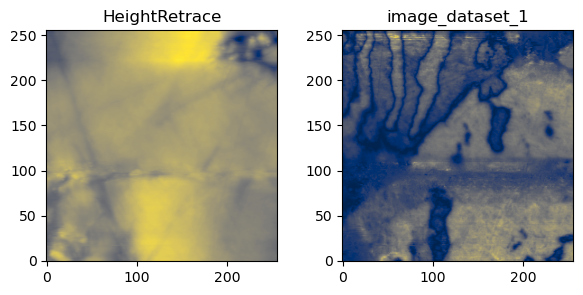

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('HeightRetrace')
ax[1].imshow(dat[1].T, cmap='cividis', origin='lower')
ax[1].set_title('image_dataset_1')

### 3. Scanning emulator

Line 23


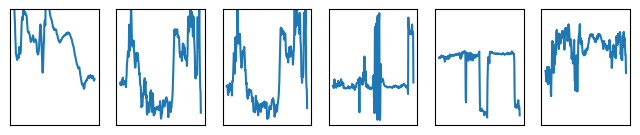

KeyboardInterrupt: 

In [20]:
gen = m.scanning_emulator(scanning_rate=5)
k = 0

print(f'Line {k}')
line = next(gen)
fig, ax = plt.subplots(1, len(line), figsize=(8,1.5))
for i, ax_ in enumerate(ax):
    ax_.plot(np.arange(len(line[i])), line[i])
    ax_.set_xticks([])
    ax_.set_yticks([])
plt.ion()  # Enable interactive mode
plt.show()
k += 1

while True:   
    line = next(gen)
    for i, ax_ in enumerate(ax):
        ax_.lines[0].set_data(np.arange(len(line[i])), line[i])
    
    clear_output(wait=True)
    print(f'Line {k}')
    display(fig)
    
    k += 1

### 4. Get individual line

In [21]:
line = m.scan_individual_line('vertical', coord = -1e-6, channels=['Amplitude1Retrace', 'Phase1Retrace'])

Amplitude1Retrace
Phase1Retrace


Text(0.5, 1.0, 'Channel_002')

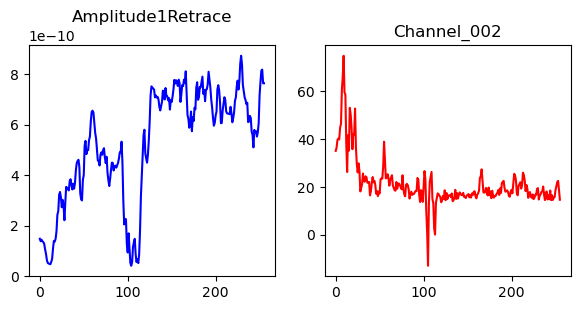

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].plot(line[0].T, color='b')
ax[0].set_title('Amplitude1Retrace')
ax[1].plot(line[1].T, color='r')
ax[1].set_title('Channel_002')

In [23]:
#print current probe position
print(f'Current location: {m.x, m.y}')

Current location: (-1e-06, 2.5e-06)


The current location to the tip corresponds to the ending point of the selected operation (scan, get individual line, etc.)

### 5. Scan arbitrary bath

In [24]:
corners = np.array([[-2e-6,2e-6],[1e-6,1.8e-6],[2.1e-6,2e-6]]) #real coordinates
dat = m.get_scan(channels=['Amplitude1Retrace',])

Amplitude1Retrace


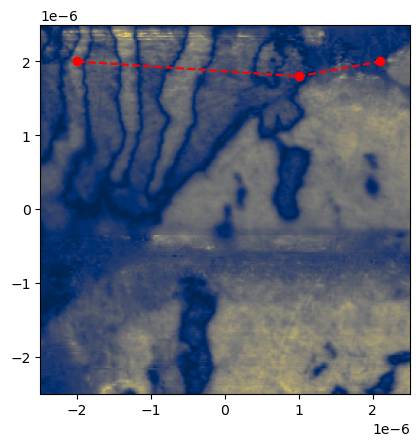

In [25]:
plt.imshow(dat[0].T, origin='lower', extent=(m.x_min, m.x_max, m.y_min, m.y_max), cmap='cividis')
plt.scatter(corners[:,0], corners[:,1], color='red')
plt.plot(*corners.T, '--', color='red')

Amplitude1Retrace


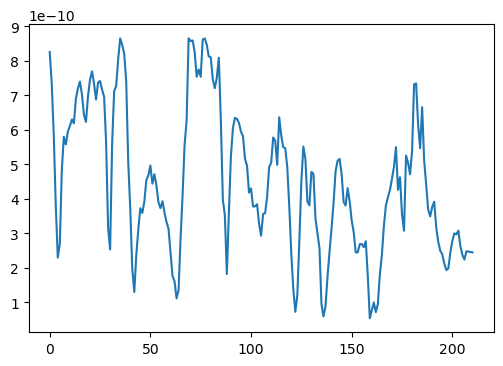

In [26]:
line = m.scan_arbitrary_path(path_points = corners, channels=['Amplitude1Retrace'])

fig = plt.figure(figsize=(6,4))
plt.plot(line[0])

### 6. Get spectral data

Get spectrum in the current probe position

In [27]:
print(f'Current position: {m.x, m.y}')

Current position: (-1e-06, 2.5e-06)


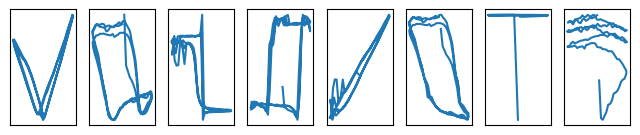

In [28]:
res = m.get_spectrum()

fig, ax = plt.subplots(1, len(res[1]), figsize=(8, 1.5))
for i in range(len(res[1])):
    ax[i].plot(res[0], res[1][i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [29]:
m.go_to(0, 1e-6)

True

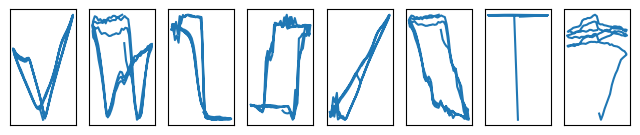

In [30]:
res = m.get_spectrum()

fig, ax = plt.subplots(1, len(res[1]), figsize=(8, 1.5))
for i in range(len(res[1])):
    ax[i].plot(res[0], res[1][i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])


## 7. Corrupted scans

### 7.1 Real tip (blunt tip)

In [31]:
kwargs = {'r_tip': 0.5, 'center': np.array([0.5, 0.5])}

mod_dict = [{'effect': real_tip, 'kwargs': kwargs},]

dat =  m.get_scan(channels=['HeightRetrace',], modification=None)
dat0 =  m.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat0.shape

HeightRetrace
HeightRetrace


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(1, 256, 256)

Text(0.5, 1.0, 'Blunt tip')

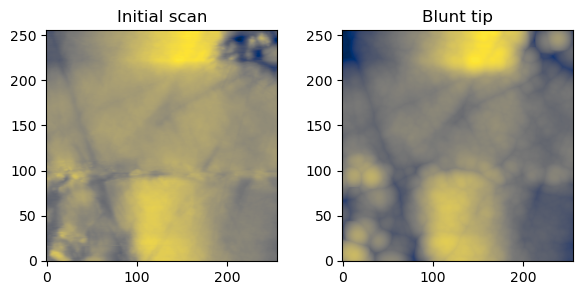

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Initial scan')
ax[1].imshow(dat0[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Blunt tip')

In [33]:
#get individual line
kwargs = {'r_tip': 0.5, 'center': np.array([0.5, 0.5])}

mod_dict = [{'effect': real_tip, 'kwargs': kwargs},]

line =  m.scan_individual_line('vertical', channels=['Amplitude1Retrace'], coord = -1e-6, modification=None)
line1 =  m.scan_individual_line('vertical', channels=['Amplitude1Retrace'],coord = -1e-6, modification=mod_dict)
line1.shape

Amplitude1Retrace
Amplitude1Retrace


(1, 256)

Text(0.5, 1.0, 'Tip doubling')

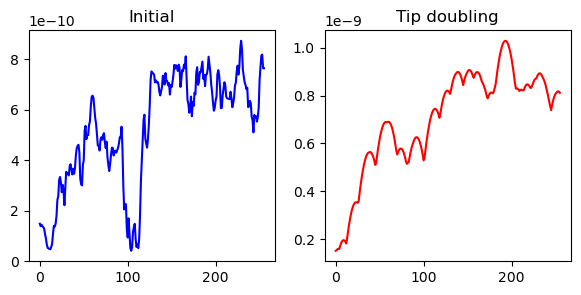

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].plot(line[0], color='b')
ax[0].set_title('Initial')
ax[1].plot(line1[0], color='r')
ax[1].set_title('Tip doubling')

### Tip doubling

In [35]:
kwargs = {'r_tip': [0.1, 0.05], 'center': [[0.2, 0.5], [0.6, 0.55]], 'length_coef': [1, 0.8]}

mod_dict = [{'effect': tip_doubling, 'kwargs': kwargs},]

dat =  m.get_scan(channels=['HeightRetrace',], modification=None)
dat0 =  m.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat0.shape

HeightRetrace
HeightRetrace


(1, 256, 256)

Text(0.5, 1.0, 'Tip doubling')

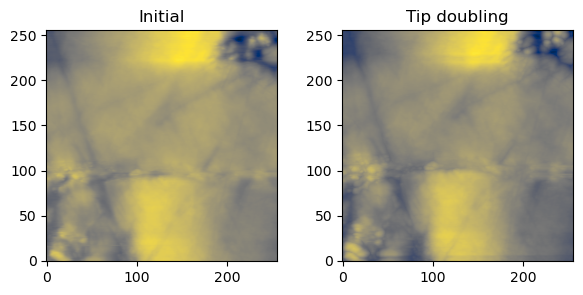

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Initial')
ax[1].imshow(dat0[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Tip doubling')

In [37]:
#get individual line
kwargs = {'r_tip': [0.05, 0.05], 'center': [[0.2, 0.5], [0.6, 0.75]], 'length_coef': [1, 0.9]}

mod_dict = [{'effect': tip_doubling, 'kwargs': kwargs},]

line =  m.scan_individual_line('vertical', channels=['Amplitude1Retrace'], coord = -1e-6, modification=None)
line1 =  m.scan_individual_line('vertical', channels=['Amplitude1Retrace'],coord = -1e-6, modification=mod_dict)
line1.shape

Amplitude1Retrace
Amplitude1Retrace


(1, 256)

Text(0.5, 1.0, 'Tip doubling')

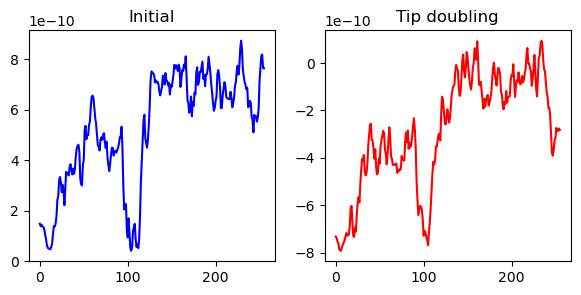

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].plot(line[0], color='b')
ax[0].set_title('Initial')
ax[1].plot(line1[0], color='r')
ax[1].set_title('Tip doubling')